In [18]:
#Import dependency
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from datetime import datetime
import requests
import psycopg2
import config as creds
import csv


In [19]:
# def connect():
    
#     # Set up a connection to the postgres server.
#     conn_string = "host="+ creds.PGHOST +" port="+ "5432" +" dbname="+ creds.PGDATABASE +" user=" + creds.PGUSER \
#                  +" password="+ creds.PGPASSWORD
    
#     conn = psycopg2.connect(conn_string)
#     #print("Connected!")

#     #Create a cursor object
#     cursor = conn.cursor()
    
#     return conn, cursor


In [20]:
# # Connecting to DB

# conn, cursor = connect()

# # SQL command to create inventory table
# sql = "select * from ames;"
# #cursor.execute(sql)
# df = pd.read_sql_query(sql, conn)
# #conn.commit()
# # dat = pd.read_sql_query(sql, conn)


In [21]:
df = pd.read_csv('Resources/cleaned_ames_dataset.csv')
df.head()

,ames_order,pid,mssubclass,mszoning,lotarea,street,lotshape,landcontour,lotconfig,landslope,...,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,total_area
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,Corner,Gtl,...,0,0,0,0,5,2010,WD,Normal,215000,4920
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,Inside,Gtl,...,0,120,0,0,6,2010,WD,Normal,105000,3404
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,Corner,Gtl,...,0,0,0,12500,6,2010,WD,Normal,172000,4299
3,4,526353030,20,RL,11160,Pave,Reg,Lvl,Corner,Gtl,...,0,0,0,0,4,2010,WD,Normal,244000,6852
4,5,527105010,60,RL,13830,Pave,IR1,Lvl,Inside,Gtl,...,0,0,0,0,3,2010,WD,Normal,189900,4668


**Final Data Cleaning before importing the dataset into our model**

In [22]:
#Drop the ames_order, pid column since it doesn't help with prediction
df.drop(columns=["ames_order"], axis=1, inplace=True)
# df.set_index(df['pid'],inplace=True)
df

,pid,mssubclass,mszoning,lotarea,street,lotshape,landcontour,lotconfig,landslope,neighborhood,...,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,total_area
0,526301100,20,RL,31770,Pave,IR1,Lvl,Corner,Gtl,NAmes,...,0,0,0,0,5,2010,WD,Normal,215000,4920
1,526350040,20,RH,11622,Pave,Reg,Lvl,Inside,Gtl,NAmes,...,0,120,0,0,6,2010,WD,Normal,105000,3404
2,526351010,20,RL,14267,Pave,IR1,Lvl,Corner,Gtl,NAmes,...,0,0,0,12500,6,2010,WD,Normal,172000,4299
3,526353030,20,RL,11160,Pave,Reg,Lvl,Corner,Gtl,NAmes,...,0,0,0,0,4,2010,WD,Normal,244000,6852
4,527105010,60,RL,13830,Pave,IR1,Lvl,Inside,Gtl,Gilbert,...,0,0,0,0,3,2010,WD,Normal,189900,4668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2757,923275080,80,RL,7937,Pave,IR1,Lvl,CulDSac,Gtl,Mitchel,...,0,0,0,0,3,2006,WD,Normal,142500,3597
2758,923276100,20,RL,8885,Pave,IR1,Low,Inside,Mod,Mitchel,...,0,0,0,0,6,2006,WD,Normal,131000,3152
2759,923400125,85,RL,10441,Pave,Reg,Lvl,Inside,Gtl,Mitchel,...,0,0,0,700,7,2006,WD,Normal,132000,2852
2760,924100070,20,RL,10010,Pave,Reg,Lvl,Inside,Mod,Mitchel,...,0,0,0,0,4,2006,WD,Normal,170000,4585


In [28]:
#dropping any NA before putting the dataset into our model
df = df.dropna()
df.isnull().sum()

pid              0
mssubclass       0
mszoning         0
lotarea          0
street           0
                ..
yrsold           0
saletype         0
salecondition    0
saleprice        0
total_area       0
Length: 66, dtype: int64

**Use Label Encoder to to transform categorical features**

In [29]:
#Convert numerical categories that shouldn't be numerical to categorical categories
#please refer to the description file for definition of each category
df['mssubclass'] = df['mssubclass'].astype(str)
df['yrsold'] = df['yrsold'].astype(str)
df['mosold'] = df['mosold'].astype(str)
df['overallcond'] = df['overallcond'].astype(str)
df['overallqual'] = df['overallqual'].astype(str)
df.dtypes

pid               int64
mssubclass       object
mszoning         object
lotarea           int64
street           object
                  ...  
yrsold           object
saletype         object
salecondition    object
saleprice         int64
total_area        int64
Length: 66, dtype: object

In [30]:
#transform text into numerical data by applying LabelEncoder 
from sklearn.preprocessing import LabelEncoder
cols = ['mssubclass', 'mszoning', 'street', 'lotshape', 'landcontour',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'salecondition',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual',
       'extercond', 'foundation', 'heating', 'heatingqc', 'centralair',
       'electrical', 'kitchenqual', 'functional', 'paveddrive', 'saletype','overallcond', 'overallqual','yrsold', 'mosold']


# # Label Encoder DataFrame for neighborhood columns
# le = LabelEncoder()
# df2 = df[['neighborhood']].copy(())
# df2['neighborhood_encoded'] = le.fit_transform(list(df['neighborhood'].values))

# print(df2.neighborhood_encoded.unique())
# print(df2.neighborhood.unique())

# Code = [15,8,25,17,2,16,19,0,18,24,23,22,9,3,20,11,4,21,7,5,6,1,14,26,13,27,10,12]
# Name = ['NAmes', 'Gilbert', 'StoneBr', 'NWAmes', 'BrDale', 'NPkVill', 'NridgHt',
#  'Blmngtn', 'NoRidge', 'Somerst', 'SawyerW', 'Sawyer', 'Greens', 'BrkSide', 
# 'OldTown', 'IDOTRR', 'ClearCr', 'SWISU', 'Edwards', 'CollgCr', 'Crawfor',
#  'Blueste', 'Mitchel', 'Timber', 'MeadowV', 'Veenker', 'GrnHill', 'Landmrk']

# df_neighborhood = pd.DataFrame(Code, Name, columns=['Label Encoder'])
# df_neighborhood

# le = LabelEncoder()
# df2 = df[['yrsold']].copy(())
# df2['yrsold_encoded'] = le.fit_transform(list(df['yrsold'].values))

# print(df2.yrsold_encoded.unique())
# print(df2.yrsold.unique())

# Code = [4,3,2,1,0]
# Name = ['2010', '2009', '2008', '2007', '2006']
# df_yrsold = pd.DataFrame(Code, Name, columns=['Label Encoder'])
# df_yrsold


# le = LabelEncoder()
# df2 = df[['overallqual']].copy(())
# df2['overallqual_encoded'] = le.fit_transform(list(df['overallqual'].values))

# print(df2.overallqual_encoded.unique())
# print(df2.overallqual.unique())

# Code = [6, 5, 7, 8, 9, 4, 3, 2, 1, 0]
# Name = ['6', '5', '7', '8', '9', '4', '3', '2', '10', '1']
# df_overallqual = pd.DataFrame(Code, Name, columns=['Label Encoder'])
# df_overallqual

values = []

for col in cols:
    
    names = df[col].unique
    print(f"names = {names}")
  
    le = LabelEncoder()
    le.fit(list(df[col].values))
    numbers = le.fit_transform(list(df[col].values))
    df[col] = numbers
    
    values.append({"names": names, "numbers": numbers})
    


names = <bound method Series.unique of 0       20
1       20
2       20
3       20
4       60
        ..
2757    80
2758    20
2759    85
2760    20
2761    60
Name: mssubclass, Length: 2762, dtype: object>
names = <bound method Series.unique of 0       RL
1       RH
2       RL
3       RL
4       RL
        ..
2757    RL
2758    RL
2759    RL
2760    RL
2761    RL
Name: mszoning, Length: 2762, dtype: object>
names = <bound method Series.unique of 0       Pave
1       Pave
2       Pave
3       Pave
4       Pave
        ... 
2757    Pave
2758    Pave
2759    Pave
2760    Pave
2761    Pave
Name: street, Length: 2762, dtype: object>
names = <bound method Series.unique of 0       IR1
1       Reg
2       IR1
3       Reg
4       IR1
       ... 
2757    IR1
2758    IR1
2759    Reg
2760    Reg
2761    Reg
Name: lotshape, Length: 2762, dtype: object>
names = <bound method Series.unique of 0       Lvl
1       Lvl
2       Lvl
3       Lvl
4       Lvl
       ... 
2757    Lvl
2758    Low
2759    Lvl


In [14]:
#put our selected features into a list

cols_8 = ["neighborhood","total_area","overallqual", "garagecars","fullbath","yearbuilt","yearremodadd","yrsold"]


#assign y to our target and x to our features 

y = df['saleprice'].values
X = df[cols_8]



Perform 80/20 data split

In [15]:
#data is split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 0)
#check the shape of each set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2209, 8), (553, 8), (2209,), (553,))

In [16]:
# Reshape the y values and then print them out
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
print(y_train.shape)
print(y_test.shape)

(2209, 1)
(553, 1)


In [17]:
# Define a scaler for the X values and the y values and fit them to the training set
X_scaler = preprocessing.StandardScaler().fit(X_train)


# Scale the training set and the testing set using the new scalers
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


#Take a log of the target to make it more normally distributed
y_train_scaled = np.log(y_train)
y_test_scaled = np.log(y_test)

**Fit data to our Multiple Linear Regression Model**

cols_final = ["pid","neighborhood","total_area","overallqual", "garagecars","fullbath","yearbuilt","yearremodadd","yrsold", "saleprice"]
df3 = df[cols_final]
df3.set_index(df['pid'],inplace=True)
df3

In [134]:
# y_hats2 = model.predict(X)
# y_hats3 = np.exp(y_hats2)
# y_hats3

C:\Users\chiko\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


array([[inf],
       [inf],
       [inf],
       ...,
       [inf],
       [inf],
       [inf]])

y_test_pred
y_test_pred = np.exp(y_test_pred)
y_test_pred

y_test_df = pd.DataFrame(y_test)
y_test_df['y_test_pred']= y_test_pred
y_test_df
y_test_df.rename(columns={0: "saleprice"}, inplace=True)
y_test_df

y_test_df.to_csv('Resources/y_test_vs_pred.csv', index=False)


**Formula for our multiple linear regression model**

y = -2.67021895e-16 + 0.03896429*neighborhood + 0.60886396*total_area + 0.13411633*overallqual + 0.08067865*garagecars + (-0.07035814*fullbath) + 0.16385461*yearbuilt +0.12970701*yearremodadd +(-0.01437204*yrsold) 

**An example of how we get the result for different number of features**

In [49]:
# cols_64 = ['mssubclass', 'mszoning', 'lotarea', 'street', 'lotshape',
#        'landcontour', 'lotconfig', 'landslope', 'neighborhood', 'condition1',
#        'condition2', 'bldgtype', 'housestyle', 'overallqual', 'overallcond',
#        'yearbuilt', 'yearremodadd', 'roofstyle', 'roofmatl', 'exterior1st',
#        'exterior2nd', 'masvnrtype', 'masvnrarea', 'exterqual', 'extercond',
#        'foundation', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf',
#        'heating', 'heatingqc', 'centralair', 'electrical', '1stflrsf',
#        '2ndflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath',
#        'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
#        'totrmsabvgrd', 'functional', 'fireplaces', 'garageyrblt', 'garagecars',
#        'garagearea', 'paveddrive', 'wooddecksf', 'openporchsf',
#        'enclosedporch', '3ssnporch', 'screenporch', 'poolarea', 'miscval',
#        'mosold', 'yrsold', 'saletype', 'salecondition','total_area']
# cols_54 = [
#        'condition2', 'bldgtype', 'housestyle', 'overallqual', 'overallcond',
#        'yearbuilt', 'yearremodadd', 'roofstyle', 'roofmatl', 'exterior1st',
#        'exterior2nd', 'masvnrtype', 'masvnrarea', 'exterqual', 'extercond',
#        'foundation', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf',
#        'heating', 'heatingqc', 'centralair', 'electrical', '1stflrsf',
#        '2ndflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath',
#        'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
#        'totrmsabvgrd', 'functional', 'fireplaces', 'garageyrblt', 'garagecars',
#        'garagearea', 'paveddrive', 'wooddecksf', 'openporchsf',
#        'enclosedporch', '3ssnporch', 'screenporch', 'poolarea', 'miscval',
#        'mosold', 'yrsold', 'saletype', 'salecondition','total_area']
# cols_44 = [
#        'condition2', 'bldgtype', 'housestyle', 'overallqual', 'overallcond',
#        'yearbuilt', 'yearremodadd', 'roofstyle', 'roofmatl', 'exterior1st',
#        'heating', 'heatingqc', 'centralair', 'electrical', '1stflrsf',
#        '2ndflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath',
#        'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
#        'totrmsabvgrd', 'functional', 'fireplaces', 'garageyrblt', 'garagecars',
#        'garagearea', 'paveddrive', 'wooddecksf', 'openporchsf',
#        'enclosedporch', '3ssnporch', 'screenporch', 'poolarea', 'miscval',
#        'mosold', 'yrsold', 'saletype', 'salecondition','total_area']
# cols_34 = [
#        'overallqual', 'overallcond',
#        'yearbuilt', 'yearremodadd', '1stflrsf',
#        '2ndflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath',
#        'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
#        'totrmsabvgrd', 'functional', 'fireplaces', 'garageyrblt', 'garagecars',
#        'garagearea', 'paveddrive', 'wooddecksf', 'openporchsf',
#        'enclosedporch', '3ssnporch', 'screenporch', 'poolarea', 'miscval',
#        'mosold', 'yrsold', 'saletype', 'salecondition','total_area']
# cols_24 = [
#        'overallqual', 'overallcond',
#        'yearbuilt', 'yearremodadd', '1stflrsf',
#        '2ndflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath',
#        'fullbath', 'halfbath', 'garagecars',
#        'garagearea', 
#        'enclosedporch', '3ssnporch', 'screenporch', 'poolarea', 'miscval',
#        'mosold', 'yrsold', 'saletype', 'salecondition','total_area']

# cols_15 = ["total_area","overallqual","grlivarea", "garagecars","garagearea","totalbsmtsf","1stflrsf","fullbath","totrmsabvgrd", "yearbuilt","yearremodadd"]

# cols_11 = ["lotconfig", "neighborhood", "bldgtype", "foundation","total_area","overallqual","totrmsabvgrd", "yearbuilt","yearremodadd"]

cols_8 = ["neighborhood","total_area","overallqual", "garagecars","fullbath","yearbuilt","yearremodadd","yrsold"]

# n = [cols_64,cols_54,cols_44,cols_34,cols_24, cols_15, cols_11, cols_8]
# #assign y to our target and x to our features 

# for i in n:
y = df['saleprice'].values
X = df[cols_8]
#data is split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 0)
#check the shape of each set
X_train.shape, X_test.shape, y_train.shape, y_test.shape
print(X_train.shape)
# Define a scaler for the X values and the y values and fit them to the training set
X_scaler = preprocessing.StandardScaler().fit(X_train)


# Scale the training set and the testing set using the new scalers
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


#Take a log to normalize the target
y_train_scaled = np.log(y_train)
y_test_scaled = np.log(y_test)

# Reshape the y values and then print them out
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

#Compare with Deep Learning Model
nn_model = tf.keras.models.Sequential()

nn_model.add(tf.keras.layers.Dense(units=len(X.columns) * 2, activation = "relu", input_dim = len(X.columns)))
nn_model.add(tf.keras.layers.Dense(units=1, activation="linear"))
nn_model.summary()
nn_model.compile(loss="mean_squared_error", optimizer="adam")
#time starting time
start_1=datetime.now()

nn_model.fit(X_train_scaled, y_train_scaled, epochs=100)
#time ending time
end_1=datetime.now()

y_train_pred = nn_model.predict(X_train_scaled)
y_test_pred = nn_model.predict(X_test_scaled)

# Evaluate the performance of the neural network
print(f"R^2 for training set: {r2_score(y_train_scaled, y_train_pred):.2f}")
print(f"R^2 for testing set: {r2_score(y_test_scaled, y_test_pred):.2f}") 

deep_model = tf.keras.models.Sequential()
deep_model.add(tf.keras.layers.Dense(units=len(X.columns) * 2, activation = "relu", input_dim = len(X.columns)))
deep_model.add(tf.keras.layers.Dense(units=len(X.columns) * 2, activation = "relu"))
deep_model.add(tf.keras.layers.Dense(units=1, activation="linear"))
deep_model.summary()

deep_model.compile(loss="mean_squared_error", optimizer="adam")
#start deep learning starting time
start_2=datetime.now()
deep_model.fit(X_train_scaled, y_train_scaled, epochs=100)
#time deep learning ending time
end_2=datetime.now()
y_train_pred = deep_model.predict(X_train_scaled)
y_test_pred = deep_model.predict(X_test_scaled)

# Evaluate the performance and run time of the deep learning model
print(f"R^2 for training set: {r2_score(y_train_scaled, y_train_pred):.2f}")
print(f"R^2 for testing set: {r2_score(y_test_scaled, y_test_pred):.2f}")
time_taken_neu = end_1 - start_1
time_taken_dl = end_2 - start_2
total_time = time_taken_dl + time_taken_neu
print(f"Time to run the model: {total_time}")

(2209, 8)
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 17        
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2209/2209 [==============================] - 1s 293us/sample - loss: 139.9683
Epoch 2/100
2209/2209 [==============================] - 0s 29us/sample - loss: 119.3776
Epoch 3/100
2209/2209 [==============================] - 0s 28us/sample - loss: 98.3583
Epoch 4/100
2209/2209 [==============================] - 0s 30us/sample - loss: 77.2181
Epoch 5/100
2209/2209 [==============================] - 0s 28us/sample - loss: 57.8598
Epoch 6/100
2209/2209 [==============================] - 0s 26us

Epoch 87/100
2209/2209 [==============================] - 0s 33us/sample - loss: 0.1015
Epoch 88/100
2209/2209 [==============================] - 0s 31us/sample - loss: 0.1002
Epoch 89/100
2209/2209 [==============================] - 0s 32us/sample - loss: 0.0968
Epoch 90/100
2209/2209 [==============================] - 0s 32us/sample - loss: 0.0937
Epoch 91/100
2209/2209 [==============================] - 0s 33us/sample - loss: 0.0915
Epoch 92/100
2209/2209 [==============================] - 0s 32us/sample - loss: 0.0893
Epoch 93/100
2209/2209 [==============================] - 0s 31us/sample - loss: 0.0867
Epoch 94/100
2209/2209 [==============================] - 0s 31us/sample - loss: 0.0844
Epoch 95/100
2209/2209 [==============================] - 0s 31us/sample - loss: 0.0826
Epoch 96/100
2209/2209 [==============================] - 0s 31us/sample - loss: 0.0796
Epoch 97/100
2209/2209 [==============================] - 0s 31us/sample - loss: 0.0783
Epoch 98/100
2209/2209 [========

2209/2209 [==============================] - 0s 34us/sample - loss: 0.0393
Epoch 72/100
2209/2209 [==============================] - 0s 32us/sample - loss: 0.0608
Epoch 73/100
2209/2209 [==============================] - 0s 33us/sample - loss: 0.0379
Epoch 74/100
2209/2209 [==============================] - 0s 33us/sample - loss: 0.0375
Epoch 75/100
2209/2209 [==============================] - 0s 37us/sample - loss: 0.0374
Epoch 76/100
2209/2209 [==============================] - 0s 31us/sample - loss: 0.0361
Epoch 77/100
2209/2209 [==============================] - 0s 35us/sample - loss: 0.0356
Epoch 78/100
2209/2209 [==============================] - 0s 33us/sample - loss: 0.0351
Epoch 79/100
2209/2209 [==============================] - 0s 32us/sample - loss: 0.0349
Epoch 80/100
2209/2209 [==============================] - 0s 36us/sample - loss: 0.0345
Epoch 81/100
2209/2209 [==============================] - 0s 33us/sample - loss: 0.0337
Epoch 82/100
2209/2209 [=====================

In [50]:

y_pred = np.exp(y_test_pred)
y_pred

array([[119404.86 ],
       [231203.42 ],
       [177967.03 ],
       [266772.12 ],
       [218692.44 ],
       [180733.75 ],
       [106023.586],
       [191090.33 ],
       [168612.81 ],
       [147252.67 ],
       [174747.34 ],
       [437074.84 ],
       [247058.   ],
       [143683.75 ],
       [151574.14 ],
       [117683.33 ],
       [101011.46 ],
       [258562.45 ],
       [153924.67 ],
       [154609.22 ],
       [458811.66 ],
       [184683.36 ],
       [215839.73 ],
       [164307.78 ],
       [297823.3  ],
       [201901.67 ],
       [195892.97 ],
       [166380.52 ],
       [ 91152.14 ],
       [104813.56 ],
       [ 98910.836],
       [248138.28 ],
       [114723.7  ],
       [142281.05 ],
       [111037.72 ],
       [188160.58 ],
       [133874.36 ],
       [237919.88 ],
       [177752.97 ],
       [191927.53 ],
       [345015.2  ],
       [204868.1  ],
       [108887.05 ],
       [176444.05 ],
       [149753.97 ],
       [265089.94 ],
       [138840.7  ],
       [13069

In [51]:
y_test_df = pd.DataFrame(y_test)
y_test_df['y_test_pred']= y_pred
y_test_df
y_test_df.rename(columns={0: "saleprice"}, inplace=True)
y_test_df

y_test_df.to_csv('Resources/y_test_vs_pred_dl.csv', index=False)

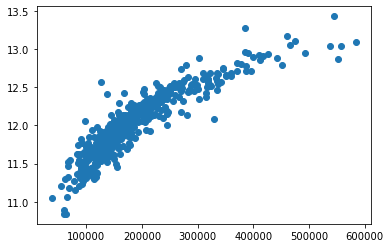

In [41]:
#graph the relationship between y_test and t_test_pred
plt.scatter(y_test, y_test_pred)
plt.show()

# Models Comparison


**Comparing Multiple Linear Regression VS Deep Learning in terms of model running time**

In [152]:
#import the recording of the model run time and model result
data = pd.read_csv('Resources/run_time_r2.csv')
data = data.dropna()
data
data['MLR_R^2'].values

,Features,MLR_R^2,MLR^Run_Time,DL_R^2,DL_Run_Time
0,64,0.90,0.006,0.91,12.12
1,54,0.90,0.003,0.89,12.38
2,44,0.89,0.003,0.87,12.18
3,34,0.88,0.003,0.81,12.53
4,24,0.86,0.003,0.85,12.31
5,15,0.85,0.002,0.82,12.44
6,11,0.85,0.002,0.88,12.71
7,9,0.85,0.002,0.89,12.80
8,8,0.86,0.002,0.89,12.38


In [154]:
data['DL_Run_Time'].values

array([12.12, 12.38, 12.18, 12.53, 12.31, 12.44, 12.71, 12.8 , 12.38])

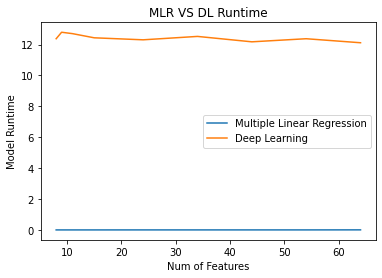

In [155]:
# MLR points 
x1 = [64,54,44,34,24,15,11,9,8] 
y1 = [0.006, 0.003, 0.003, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002] 
# plotting the line 1 points  
plt.plot(x1, y1, label = "Multiple Linear Regression") 
  
# DL points 
x2 = [64,54,44,34,24,15,11,9,8] 
y2 = [12.12, 12.38, 12.18, 12.53, 12.31, 12.44, 12.71, 12.8 , 12.38] 
# plotting the DL points  
plt.plot(x2, y2, label = "Deep Learning") 
  
# naming the x axis 
plt.xlabel('Num of Features') 
# naming the y axis 
plt.ylabel('Model Runtime') 
# giving a title to my graph 
plt.title('MLR VS DL Runtime') 
  
# show a legend on the plot 
plt.legend() 
  
# function to show the plot 
plt.show() 

**Comparing Multiple Linear Regression VS Deep Learning in terms of R^2**

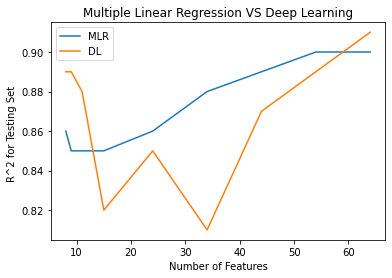

In [149]:
x = data.Features
MLR = data['MLR_R^2']
DL = data['DL_R^2']
fig, ax = plt.subplots()
ax.plot(x,MLR, label='MLR')
ax.plot(x,DL, label='DL')
ax.set_title("Multiple Linear Regression VS Deep Learning")
ax.set_xlabel("Number of Features")
ax.set_ylabel("R^2 for Testing Set ")
ax.legend()

In [ ]:
#Other
# X_scaler.scale_
# X_scaler.inverse_transform
# y_test_pred = np.exp(y_test_pred)
# X_scaler.inverse_transform